In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

import sys
if '..' not in sys.path:
    sys.path.append('..')


import pandas as pd
import numpy as np
import networkx as nx
import copy
import scipy as sp
import math
import seaborn
import pickle
import warnings
import matplotlib
import re
# import multiprocessing

# from lib.mobilitysim import MobilitySimulator
from lib.dynamics import DiseaseModel
from lib.distributions import CovidDistributions
from lib.plot import Plotter
from lib.data import collect_data_from_df
from lib.measures import (
    MeasureList, 
    BetaMultiplierMeasure, 
    BetaMultiplierMeasureByType,
    SocialDistancingForAllMeasure, 
    SocialDistancingForKGroups,
    SocialDistancingByAgeMeasure,
    SocialDistancingForPositiveMeasure, 
    ComplianceForAllMeasure,
    Interval)
from lib.runutils import save_summary, load_summary

# from lib.mobilitysim import MobilitySimulator
# from lib.town_data import generate_population, generate_sites, compute_distances
# from lib.town_maps import MapIllustrator

In [5]:
# Plot results of experiments_server_6-1.py
summaries_SD_5 = load_summary('summaries_r12.pk')

start_date = '2020-03-08'
end_date = '2020-03-27'

isolation_days = [7] # how many days selected people have to stay in isolation
contacts_isolated = [10,25] # how many contacts are isolated in the `test_smart_delta` window
duration_weeks_SD_5 = 12 # strategies tested for 12 weeks starting today
FIGSIZE=(6, 4)
c=0
runstr = f'run{c}_'

plotter = Plotter()
for i, days in enumerate(isolation_days):
    for j, contacts in enumerate(contacts_isolated):
        summaries_ = summaries_SD_5[(days, contacts)]
        titles_SD_5_ = ['No contact tracing', 'Basic contact tracing', 'Advanced contact tracing']
        plotter.compare_total_infections(
            summaries_,
            start_date=start_date,
            titles=titles_SD_5_, 
            figtitle=(f'Strategies for isolating {contacts} contacts.\n'
                      f'Selected people are isolated for {days} days.'),
            filename=runstr + f'SD_5{i}{j}', 
            figsize=FIGSIZE, acc=500, 
            ymax=5000, errorevery=14)

FileNotFoundError: [Errno 2] No such file or directory: 'summaries/summaries_r12.pk'

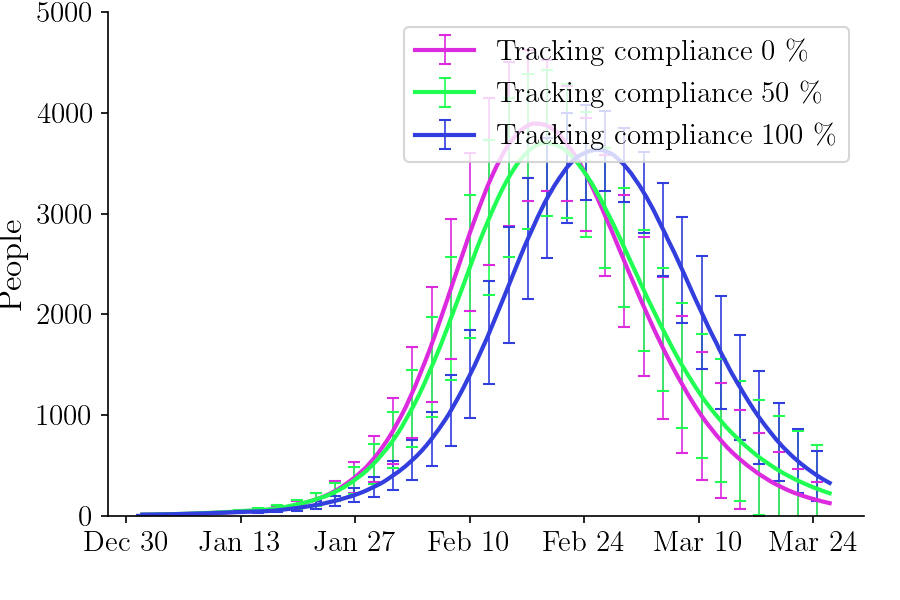

In [7]:
# Plot results of experiments_server_7-1.py
c=0
runstr = f'run{c}_'
summaries_SD_6 = load_summary('summaries_r15.pk')
FIGSIZE=(6, 4)

p_compliance = [0.0, 0.5, 1.0]
plotter = Plotter()
titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])
for j, policy in enumerate(['advanced']):
    summaries_ = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_, 
        titles=titles_SD_6_, 
        figtitle=(f'Infections for compliance levels for ' + policy + ' individuals compliant with contact-tracing'),
        filename=runstr + f'SD_6{j}', 
        figsize=FIGSIZE, acc=500, 
        ymax=5000, errorevery=14)

In [ ]:
# TODO: Plot results of experiments_essential_fixed.py
c=0
runstr = f'run{c}_'
summaries_SD_6 = load_summary('summaries_r8.pk')
FIGSIZE=(6, 4)

p_compliance = [0.0, 0.25, 0.5, 0.75, 1.0]
plotter = Plotter()
titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])
for j, policy in enumerate(['random', 'essential']):
    summaries_ = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_, 
        titles=titles_SD_6_, 
        figtitle=(f'Infections for compliance levels for ' + policy + ' individuals compliant with contact-tracing'),
        filename=runstr + f'SD_6{j}', 
        figsize=FIGSIZE, acc=500, 
        ymax=2000, errorevery=14)